In [1]:
#@title Install arviz
# !pip3 install arviz

In [2]:
import arviz as az
import pystan
import os
# os.environ['STAN_NUM_THREADS'] = "4"
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [3]:
stancode = """
functions {
            real[] SIR(real t,  // time
            real[] u,           // system state {infected,cases,susceptible}
            real[] theta,       // parameters 
            real[] x_r,
            int[] x_i) {

            real du_dt[2];
        
            real beta = theta[1];
            real sigmac = theta[2];
            real sigmar = theta[3];
            real sigmad =  theta[4];
            real q = theta[5]; 
            real f = theta[6]; 
            real mbase = theta[7]; 
            real mlocation = theta[8]; 
            real mrate = theta[9]; 
            real cmax = theta[10];
            real c50 = theta[11];
            
            real I = u[1];  # unknown infected
            real C = u[2];  # cases
            
            beta *= mbase + (1-mbase)/(1 + exp(mrate*(t - mlocation)));
            sigmac *= 1 + cmax*t/(c50+t);
            
            
            du_dt[1] = beta*(I+q*C) - sigmac*I - f*(sigmar+sigmad)*I; //I
            du_dt[2] = sigmac*I - (sigmar+sigmad)*C; //C
            
            return du_dt;
          }
        }

        data {
          int<lower = 1> n_obs;       // number of days observed
          int<lower = 1> n_theta;     // number of model parameters
          int<lower = 1> n_difeq;     // number of differential equations for yhat
          int<lower = 1> n_ostates;     // number of observed states
          int<lower = 1> n_pop;       // population
          real<lower = 1> n_scale;       // scale to match observed scale
          int y[n_obs,n_ostates];           // data, per-day-tally [cases,recovered,death]
          real t0;                // initial time point 
          real tm; //start day of mitigation
          real ts[n_obs];         // time points that were observed
          int<lower = 1> n_obs_predict;       // number of days to predict
          real ts_predict[n_obs_predict];         // 
        }

        transformed data {
            real x_r[0];
            int x_i[0];           
        }

        parameters {
            real<lower = 0> theta[n_theta]; // model parameters 
        }

        transformed parameters{
            real u[n_obs, n_difeq]; // solution from the ODE solver
            real u_init[n_difeq];     // initial conditions for fractions
            
            real beta = theta[1];
            real sigmac = theta[2];
            real sigmar = theta[3];
            real sigmad =  theta[4];
            real q = theta[5]; 
            real f = theta[6]; 
            real mbase = theta[7]; 
            real mlocation = theta[8]; 
            real mrate = theta[9]; 
            real cmax = theta[10];
            real c50 = theta[11];
            real theta_init = theta[12];
                        
            u_init[1] = theta_init/n_scale; // I
            u_init[2] = y[1,1]/n_scale; //C
                     
            //print(theta)
            u = integrate_ode_rk45(SIR, u_init, t0, ts, theta, x_r, x_i);
  
        }

        model {
            real lambda[n_obs,3]; //poisson parameter [cases, deaths, recovered]

            //priors
            
            //for (i in 1:n_theta){theta[1] ~ lognormal(log(0.1),10);};
            //theta[5] ~ lognormal(log(0.25),10);
            
            
            //real beta = theta[1];
            //real sigmac = theta[2];
            //real sigmar = theta[3];
            //real sigmad =  theta[4];
            //real q = theta[5]; 
            //real f = theta[6]; 
            //real mbase = theta[7]; 
            //real mlocation = theta[8]; 
            //real mrate = theta[9]; 
            //real cmax = theta[10];
            //real c50 = theta[11];
            
            // [0.25,
            //0.1,
            //0.01,
            //0.01,
            //0.01,
            //1.0,
            //0.1,
            //1.0,
            //1.0,
            //0.1,
            //10.0,
            //1.0]

            theta[1] ~ lognormal(log(0.25),1); //beta 
            theta[2] ~ lognormal(log(0.1),1); //sigmac
            theta[3] ~ lognormal(log(0.01),1); //sigmar
            theta[4] ~ lognormal(log(0.01),1); //sigmad
            theta[5] ~ lognormal(log(0.01),1); //q
            theta[6] ~ lognormal(log(1),1); //f
            theta[7] ~ lognormal(log(0.1),1); //mbase  
            theta[8] ~ lognormal(log(tm),5); //mlocation 
            theta[9] ~ lognormal(log(1),5); //mrate
            theta[10] ~ lognormal(log(0.1),1);//cmax 
            theta[11] ~ lognormal(log(10),1);//c50 
            theta[12] ~ lognormal(log(1),1);// theta_init 

          
            //likelihood
            lambda[1,1] = .5*(u[1,1]+u_init[1])*sigmac*n_scale; //C: cases sigma_c*\int I
            lambda[1,2] = .5*(u[1,2]+u_init[2])*sigmar*n_scale; //R: recovered sigma_r*\int C
            lambda[1,3] = .5*(u[1,2]+u_init[2])*sigmad*n_scale; //D: dead sigma_d * \int C
        
            target += poisson_lpmf(y[1,1]|max([lambda[1,1],0.0])); //C
            target += poisson_lpmf(y[1,2]|max([lambda[1,2],0.0])); //R
            target += poisson_lpmf(y[1,3]|max([lambda[1,3],0.0])); //D

            
            for (i in 2:n_obs){
                lambda[i,1] = .5*(u[i,1]+u[i-1,1])*sigmac*n_scale; //C: cases sigma_c*\int_{interval} I
                lambda[i,2] = .5*(u[i,2]+u[i-1,2])*sigmar*n_scale; //R: recovered sigma_r*C
                lambda[i,3] = .5*(u[i,2]+u[i-1,2])*sigmad*n_scale; //D: dead
            
                target += poisson_lpmf(y[i,1]|max([lambda[i,1],0.0])); //C
                target += poisson_lpmf(y[i,2]|max([lambda[i,2],0.0])); //R
                target += poisson_lpmf(y[i,3]|max([lambda[i,3],0.0])); //D
            }

        }

        generated quantities {
            real R_0;      // Basic reproduction number
            real sigma_ = theta[2] + theta[3] + theta[4];
            real beta_ = theta[1];
            real u_predict[n_obs_predict, n_difeq]; // solution from the ODE solver
            
            real ll_[n_obs]; // log-likelihood for model
            real lambda[n_obs,3]; //poisson parameter [cases, deaths, recovered]
            
            R_0 = beta_/sigma_;

            //likelihood
            lambda[1,1] = .5*(u[1,1]+u_init[1])*sigmac*n_scale; //C: cases sigma_c*\int I
            lambda[1,2] = .5*(u[1,2]+u_init[2])*sigmar*n_scale; //R: recovered sigma_r*\int C
            lambda[1,3] = .5*(u[1,2]+u_init[2])*sigmad*n_scale; //D: dead sigma_d * \int C
            
            ll_[1] = poisson_lpmf(y[1,1]|max([lambda[1,1],0.0]));
            ll_[1] += poisson_lpmf(y[1,2]|max([lambda[1,2],0.0]));
            ll_[1] += poisson_lpmf(y[1,3]|max([lambda[1,3],0.0]));

            
            for (i in 2:n_obs){
                lambda[i,1] = .5*(u[i,1]+u[i-1,1])*sigmac*n_scale; //C: cases sigma_c*\int_{interval} I
                lambda[i,2] = .5*(u[i,2]+u[i-1,2])*sigmar*n_scale; //R: recovered sigma_r*C
                lambda[i,3] = .5*(u[i,2]+u[i-1,2])*sigmad*n_scale; //D: dead

                ll_[i] = poisson_lpmf(y[i,1]|max([lambda[i,1],0.0]));
                ll_[i] += poisson_lpmf(y[i,2]|max([lambda[i,2],0.0]));
                ll_[i] += poisson_lpmf(y[i,3]|max([lambda[i,3],0.0]));
            }
         
        //u_init[2] = y[1,1]/n_scale; //C
        //u_init[1] = (beta - (sigmar+sigmad))/sigmac * u_init[2] + theta_init/n_scale; // I
                  
        //u_predict = integrate_ode_rk45(SIR, u_init, t0, ts_predict, theta, x_r, x_i);   

        }
        """

In [4]:
stanrunmodel = pystan.StanModel(model_code=stancode)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_647565f6481cb4a92d085ae0154ccbb9 NOW.


# Load data from Gerkin scrape

t0 index assumed to be: day 36
t0 date: 2/27/20
tm index assumed to be: day 50
mitigation date: 3/12/20


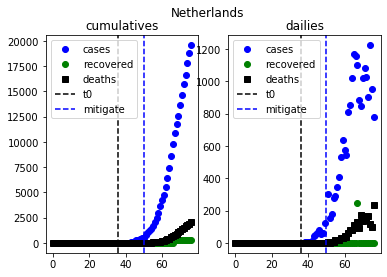

In [5]:
roi = "Netherlands"

DF = pd.read_csv("../data/covid_timeseries_"+roi+".csv")

pop = {}
pop['Italy'] = 60500000
pop['United Kingdom'] = 64400000
pop['France'] = 66990000
pop['Netherlands'] = 17000000

mitigate = {}
mitigate['Italy'] = '3/9/20' #approximate date
mitigate['Netherlands'] = '3/12/20' #approximate date

# t0 := where to start time series, index space
t0 = np.where(DF["new_cases"].values>=1)[0][0] 
# tm := start of mitigation, index space
tm = np.where(mitigate[roi]==DF['dates2'])[0][0]

#plot the data with important time stamps (t0, tm)
plt.subplot(1,2,1)
plt.title('cumulatives')
plt.plot(DF["cum_cases"],'bo', label="cases")
plt.plot(DF["cum_recover"],'go',label="recovered")
plt.plot(DF["cum_deaths"],'ks',label="deaths")

plt.axvline(t0,color='k', linestyle="dashed", label='t0')
plt.axvline(tm,color='b', linestyle="dashed", label='mitigate')
plt.legend()


plt.subplot(1,2,2)
plt.title('dailies')
plt.plot(DF["new_cases"],'bo', label="cases")
plt.plot(DF["new_recover"],'go',label="recovered")
plt.plot(DF["new_deaths"],'ks',label="deaths")
plt.axvline(t0,color='k', linestyle="dashed", label='t0')
plt.axvline(tm,color='b', linestyle="dashed", label='mitigate')
plt.suptitle(roi)
plt.legend()


print("t0 index assumed to be: day "+str(t0))
print("t0 date: "+DF['dates2'][t0])
print("tm index assumed to be: day "+str(tm))
print("mitigation date: "+DF['dates2'][tm])



## Format JHU ROI data for Stan

In [6]:
# int<lower = 1> n_obs;       // number of days observed
# int<lower = 1> n_theta;     // number of model parameters
# int<lower = 1> n_difeq;     // number of differential equations for yhat
# int<lower = 1> n_ostates;     // number of observed states
# int<lower = 1> n_pop;       // population
# real<lower = 1> n_scale;       // scale to match observed scale
# int y[n_obs,n_ostates];           // data, per-day-tally [cases,recovered,death]
# real t0;                // initial time point 
# real tm; //start day of mitigation
# real ts[n_obs];         // time points that were observed
# int<lower = 1> n_obs_predict;       // number of days to predict
# real ts_predict[n_obs_predict];         // 

stan_data = {}

stan_data['n_pop'] = pop[roi] 
stan_data['n_scale'] = 10000000 #use this instead of population

stan_data['n_theta'] = 12
stan_data['n_difeq'] = 2
stan_data['n_ostates'] = 3

stan_data['t0'] = t0-1 #to for ODE is one day, index before start of series
stan_data['tm'] = tm
stan_data['ts'] = np.arange(t0,len(DF['dates2'])) 
# DF = DF.replace('NaN', 0)
# DF = DF.replace(-1, 0)
stan_data['y'] = (DF[['new_cases','new_recover','new_deaths']].to_numpy()).astype(int)[t0:,:]
stan_data['n_obs'] = len(DF['dates2']) - t0

#forward predict n days from t0
#returns uhat
stan_data['ts_predict'] = np.arange(t0,len(DF['dates2'])+365)
stan_data['n_obs_predict'] = len(DF['dates2']) - t0 + 365

### Print data for Stan 

In [7]:
print(stan_data)

{'n_pop': 17000000, 'n_scale': 10000000, 'n_theta': 12, 'n_difeq': 2, 'n_ostates': 3, 't0': 35, 'tm': 50, 'ts': array([36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76]), 'y': array([[   1,    0,    0],
       [   0,    0,    0],
       [   5,    0,    0],
       [   4,    0,    0],
       [   8,    0,    0],
       [   6,    0,    0],
       [  14,    0,    0],
       [  44,    0,    0],
       [  46,    0,    1],
       [  60,    0,    0],
       [  77,    0,    2],
       [  56,    0,    0],
       [  61,    0,    1],
       [ 121,    0,    1],
       [   0,    0,    0],
       [ 301,    0,    5],
       [ 155,    2,    2],
       [ 176,    0,    8],
       [ 278,    0,    4],
       [ 292,    0,   19],
       [ 346,    0,   15],
       [ 409,    0,   18],
       [ 534,    0,   30],
       [ 637,    0,   30],
       [ 573,    0,   43],
       [ 545,    0,  

# Load England School 1978 Influenza data 

In [8]:
# #England 1978 influenza
# cases = [0,8,26,76,225,298,258,233,189,128,150,85,14,4]
# recovered = [0,0,0,0,9,17,105,162,176,166,150,85,47,20]
# plt.plot(cases,'bo', label="cases")
# plt.plot(recovered,'go',label="recovered")
# pop = 763
# model.stan_data['t0'] = 0
# #truncate time series from t0 on (initial is t0-1)
# model.stan_data['n_pop'] = pop 
# model.stan_data['ts'] = np.arange(1,len(cases)+1)  
# Y = np.hstack([np.c_[cases],np.c_[recovered],np.zeros((len(cases),1))]).astype(int)
# model.stan_data['y'] = Y
# model.stan_data['n_obs'] = len(cases)

# plt.plot(cases,'bo', label="cases")
# plt.plot(recovered,'go',label="recovered")

# plt.legend()

# Run Stan 

## Initialize parameters

In [9]:
# theta[1] ~ lognormal(log(0.25),1); //beta 
# theta[2] ~ lognormal(log(0.1),1); //sigmac
# theta[3] ~ lognormal(log(0.01),1); //sigmar
# theta[4] ~ lognormal(log(0.01),1); //sigmad
# theta[5] ~ lognormal(log(0.01),1); //q
# theta[6] ~ lognormal(log(1),1); //f
# theta[7] ~ lognormal(log(0.1),1); //mbase  
# theta[8] ~ lognormal(log(tm),5); //mlocation 
# theta[9] ~ lognormal(log(1),5); //mrate
# theta[10] ~ lognormal(log(0.1),1);//cmax 
# theta[11] ~ lognormal(log(10),1);//c50 
# theta[12] ~ lognormal(log(1),1);// theta_init 
init = [{'theta':[0.25,0.1,0.01,0.01,0.01,1.0,0.1,1.0,1.0,0.1,10.0,1.0]}]
    
def init_fun():
        x = {'theta':
             [np.random.lognormal(np.log(0.25),1)]+
             [np.random.lognormal(np.log(0.1),1)]+
             [np.random.lognormal(np.log(0.01),1)]+
             [np.random.lognormal(np.log(0.01),1)]+
             [np.random.lognormal(np.log(0.01),1)]+
             [np.random.lognormal(np.log(1),1)]+
             [np.random.lognormal(np.log(0.1),1)]+
             [np.random.lognormal(np.log(stan_data['tm']),5)]+
             [np.random.lognormal(np.log(1),5)]+
             [np.random.lognormal(np.log(0.1),1)]+
             [np.random.lognormal(np.log(10),1)]+
             [np.random.lognormal(np.log(1),1)]
            }
        return x


## Fit Stan 

In [12]:
n_chains=1
n_warmups=1000
n_iter=5000
n_thin=50

control = {'adapt_delta':0.95}
fit = stanrunmodel.sampling(data = stan_data,init = init_fun ,control=control, chains = n_chains, warmup = n_warmups, iter = n_iter, thin=n_thin, seed=13219)


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [21]:
pystan.check_hmc_diagnostics(fit)

{'n_eff': False,
 'Rhat': False,
 'divergence': True,
 'treedepth': False,
 'energy': True}

In [13]:
print(fit)

Inference for Stan model: anon_model_647565f6481cb4a92d085ae0154ccbb9.
1 chains, each with iter=5000; warmup=1000; thin=50; 
post-warmup draws per chain=80, total post-warmup draws=80.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]           2.57    0.08   0.31   1.84   2.41   2.57   2.76   3.16     16   0.99
theta[2]           1.43    0.09   0.34   0.66   1.25   1.46   1.62   2.05     14    1.0
theta[3]         7.3e-4  3.0e-5 1.1e-4 4.7e-4 6.6e-4 7.4e-4 8.0e-4 9.3e-4     15   1.02
theta[4]         6.0e-3  2.6e-4 8.8e-4 3.9e-3 5.7e-3 6.1e-3 6.7e-3 7.3e-3     12   1.01
theta[5]         2.1e-4  2.4e-5 1.1e-4 4.6e-5 1.4e-4 2.0e-4 2.7e-4 4.6e-4     20   0.99
theta[6]           1.87    0.38   2.02   0.31   0.76   1.29    2.3   7.31     28    1.0
theta[7]           0.07    0.01   0.02   0.03   0.04   0.07   0.09    0.1      3   2.65
theta[8]          3.9e5   9.1e4  1.9e5  5.0e4  2.4e5  3.9e5  5.0e5  7.8e5      4   1.72
theta[9]         3.4e-

array([<matplotlib.axes._subplots.AxesSubplot object at 0x129551e90>,
      dtype=object)

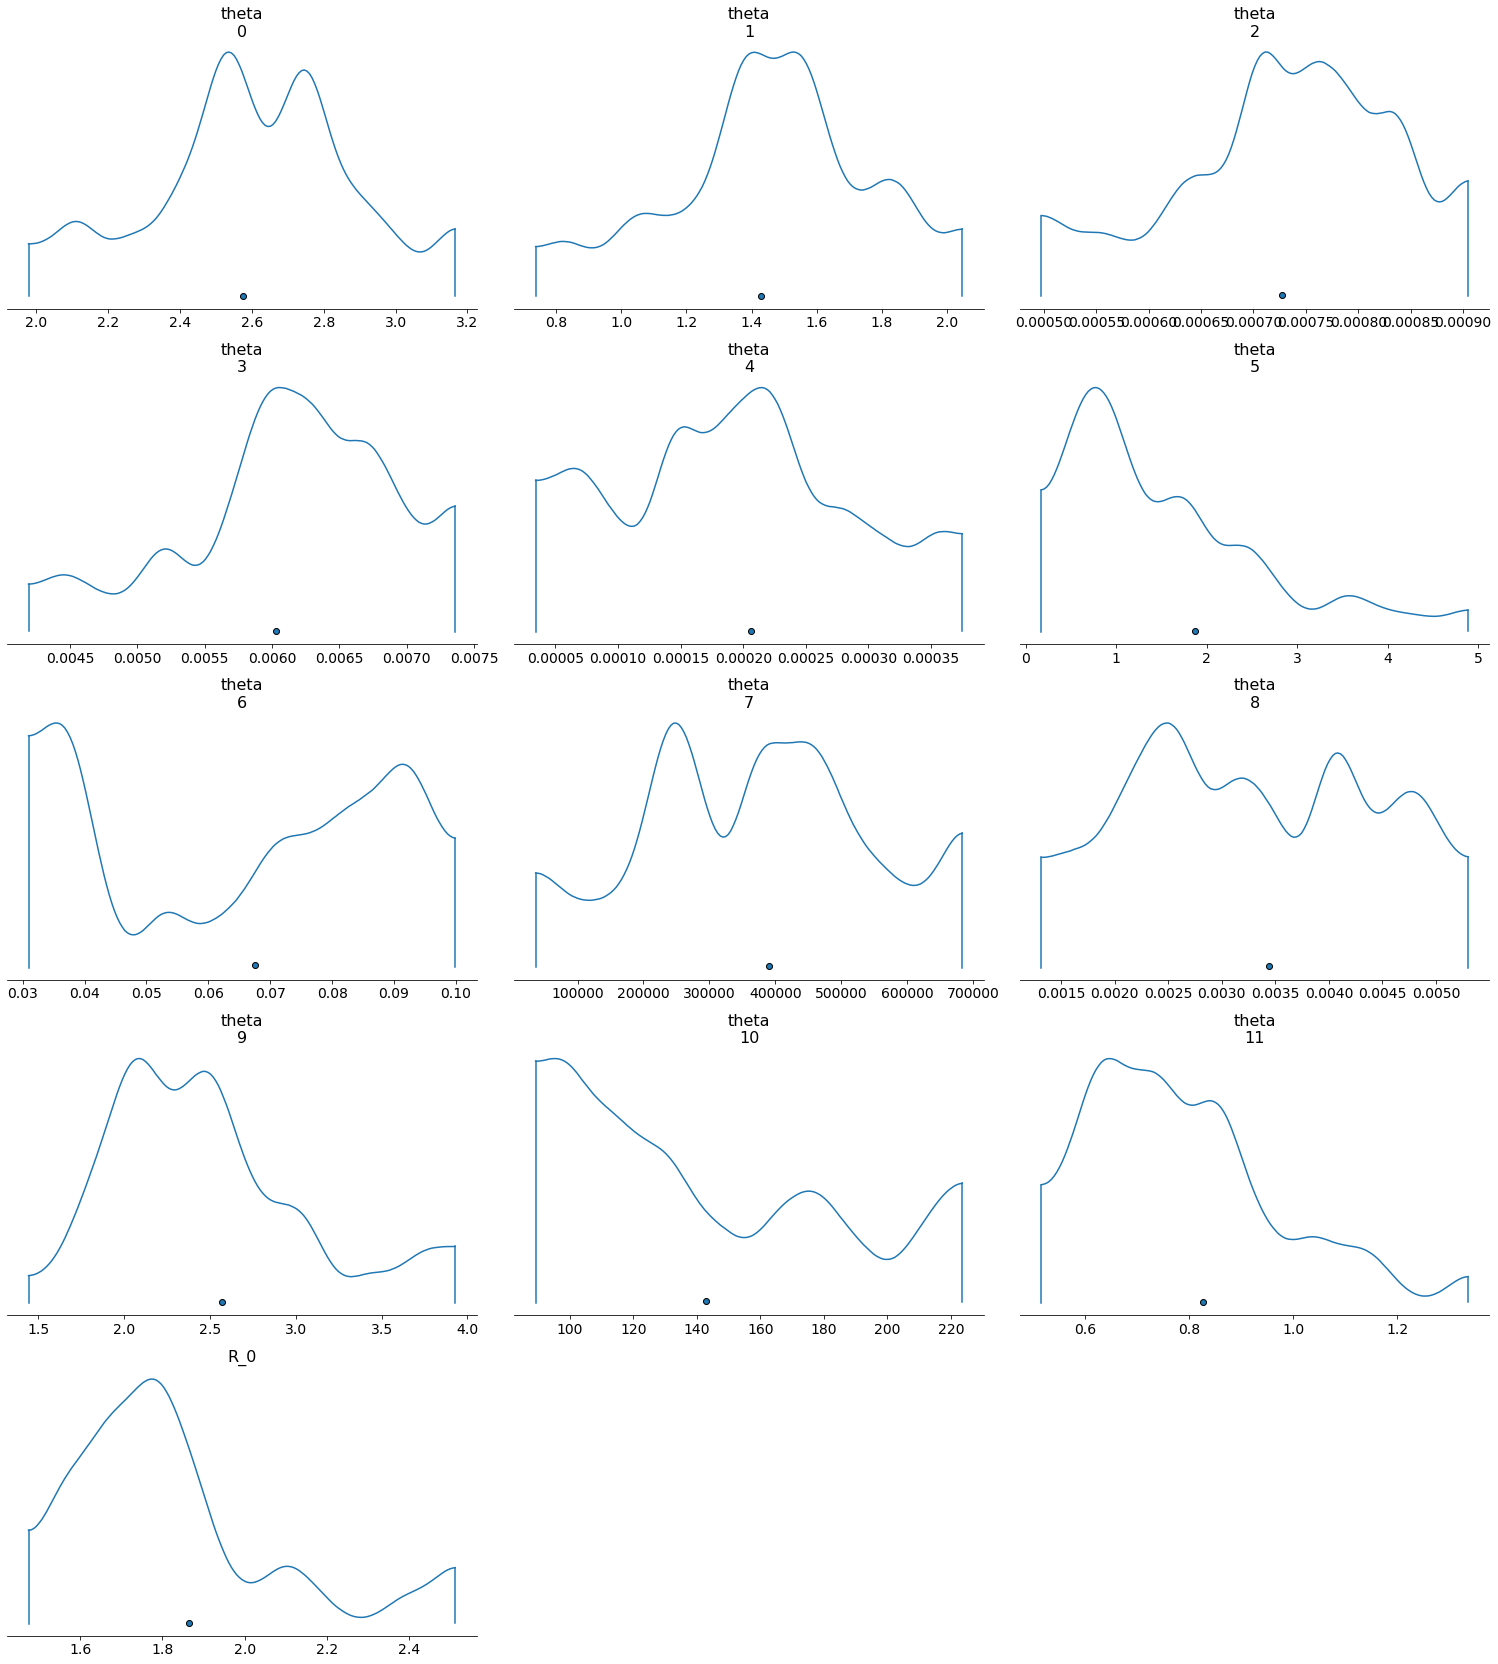

In [14]:
#https://arviz-devs.github.io/arviz/generated/arviz.plot_density
az.plot_density(fit,group='posterior',var_names=["theta","R_0"])

(80, 41, 2)
(80, 12)


(0, 2000)

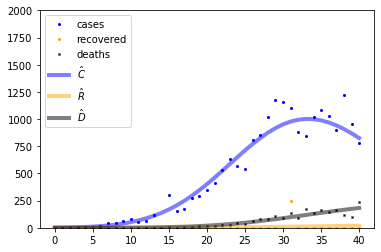

In [31]:
print(np.shape(fit.extract()['u']))
print(np.shape(fit.extract()['theta']))

ms=2 

x = range(len(DF["new_cases"][t0:]))
     
plt.plot(x,DF["new_cases"][t0:],'bo', label="cases",ms=ms)
plt.plot(x,DF["new_recover"][t0:],'o',color='orange',label="recovered",ms=ms)
plt.plot(x,DF["new_deaths"][t0:],'x',color='k',label="deaths",ms=ms)
  
lw=4
alpha = 0.5

Chat = stan_data['n_scale']*(fit.extract()['theta'][-1,1])*fit.extract()['u'][-1,:,0]
Rhat = stan_data['n_scale']*(fit.extract()['theta'][-1,2])*fit.extract()['u'][-1,:,1]
Dhat = stan_data['n_scale']*(fit.extract()['theta'][-1,3])*fit.extract()['u'][-1,:,1]
plt.plot(Chat,label=r'$\hat{C}$',lw=lw,alpha=alpha,color='b')
plt.plot(Rhat,label=r'$\hat{R}$',lw=lw,alpha=alpha,color='orange')
plt.plot(Dhat,label=r'$\hat{D}$',lw=lw,alpha=alpha,color='k')

plt.legend()
plt.ylim((0,2000))
